In [ ]:
# Install required packages (Colab environment setup)
!pip install torch torchvision torchmetrics --quiet
!pip uninstall -y torch-fidelity -q
!pip install torch-fidelity==0.3.0 --quiet
!pip install matplotlib tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 66.0 MB/s eta 0:00:00


In [ ]:
# Imports and reproducibility
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

# For evaluation metrics
from torchvision.datasets import CIFAR10
from torchvision.models.inception import inception_v3
import torch.nn.functional as F
from PIL import Image
from torch_fidelity import calculate_metrics
from scipy.stats import entropy
import pandas as pd
from torchvision import transforms

In [ ]:
# Set random seed for reproducibility of results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
cudnn.deterministic = True
cudnn.benchmark = False

In [ ]:
# Mount Google Drive for storing experiment results
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### E1_Baseline

In [ ]:
# Experiment configuration (E1 baseline)
experiment_id = "E1_Baseline"

config = {
    "experiment_id": experiment_id,     # Experiment ID matches report table
    "model": "DCGAN",                   # Architecture used
    "regularization_type": None,        # No regularization in baseline
    "regularization_lambda_L1": 0.0,
    "regularization_lambda_L2": 0.0,
    "regularization_placement": None,   # No placement since no regularization
    "dataset": "CIFAR-10",
    "image_size": 32,
    "latent_dim": 100,                  # Dimensionality of noise vector z
    "num_epochs": 100,
    "batch_size": 128,
    "optimizer": "Adam",
    "learning_rate": 0.0002,
    "beta1": 0.5,
    "fid_samples": 10000,               # Number of images for FID/IS eval
    "save_images_every": 10,            # Save sample grid every N epochs
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "pytorch_version": torch.__version__,
    "cuda_version": torch.version.cuda if torch.cuda.is_available() else "None",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu").type
}

In [ ]:
# Create experiment output folders in Drive
ROOT_DIR = "/content/drive/MyDrive/GAN_Research/"
exp_path = os.path.join(ROOT_DIR, experiment_id)

for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config file for full traceability
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E1_Baseline/config_manual.txt


In [ ]:
# Prepare fixed noise for sample images
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
noise_path = os.path.join(exp_path, "fixed_noise.pt")
torch.save(fixed_noise, noise_path)

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)     # Normalization to [-1, 1]
])
dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
print(f"CIFAR-10 loaded: {len(dataset)} images, Batch size: {config['batch_size']}")

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


CIFAR-10 loaded: 50000 images, Batch size: 128


In [ ]:
# Define Generator and Discriminator (DCGAN)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_maps=64, out_channels=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # First layer: fully-connected transpose conv from noise
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),

            # Upsampling layers
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # Output RGB image with Tanh to match normalization
            nn.ConvTranspose2d(feature_maps, out_channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            # Downsampling conv layers
            nn.Conv2d(in_channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Output single probability via Sigmoid
            nn.Conv2d(feature_maps * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.main(img).view(-1, 1)

In [ ]:
# Initialize models and apply DCGAN weight init
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 or classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

G.apply(weights_init)
D.apply(weights_init)
print("Generator and Discriminator initialized.")

Generator and Discriminator initialized.


In [ ]:
# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

        # Real images
        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        # Fake images
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        # Train D loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Save images
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            sample_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(sample_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        checkpoint = {
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }
        torch.save(checkpoint, checkpoint_path)

    # Log average losses
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)

    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save losses to CSV
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Save total training time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 0.6829, Loss_G: 2.2611
[Epoch 2/100] Loss_D: 0.9266, Loss_G: 2.2772
[Epoch 3/100] Loss_D: 0.9702, Loss_G: 2.0095
[Epoch 4/100] Loss_D: 1.0438, Loss_G: 1.7816
[Epoch 5/100] Loss_D: 1.1391, Loss_G: 1.4380
[Epoch 6/100] Loss_D: 1.1416, Loss_G: 1.4816
[Epoch 7/100] Loss_D: 1.0989, Loss_G: 1.4955
[Epoch 8/100] Loss_D: 1.0283, Loss_G: 1.6086
[Epoch 9/100] Loss_D: 1.0112, Loss_G: 1.7331
[Epoch 10/100] Loss_D: 0.9764, Loss_G: 1.7657
[Epoch 11/100] Loss_D: 0.9786, Loss_G: 1.7815
[Epoch 12/100] Loss_D: 0.9785, Loss_G: 1.7551
[Epoch 13/100] Loss_D: 0.9513, Loss_G: 1.7207
[Epoch 14/100] Loss_D: 0.9293, Loss_G: 1.7766
[Epoch 15/100] Loss_D: 0.8960, Loss_G: 1.8130
[Epoch 16/100] Loss_D: 0.8931, Loss_G: 1.8299
[Epoch 17/100] Loss_D: 0.8521, Loss_G: 1.8922
[Epoch 18/100] Loss_D: 0.8193, Loss_G: 1.9639
[Epoch 19/100] Loss_D: 0.8330, Loss_G: 1.9601
[Epoch 20/100] Loss_D: 0.8032, Loss_G: 1.9797
[Epoch 21/100] Loss_D: 0.7544, Loss_G: 2.083

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print("No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E1_Baseline/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E1_Baseline/metrics/loss_curve.png


In [ ]:
# Evaluation: Save images, calculate FID & Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval_data folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    eval_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics["frechet_inception_distance"]

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:52<00:00,  1.48it/s]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 32.2MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/loca


FID: 47.6336
Inception Score: 3.5376 ± 0.0812


### E2_L1_GenOut

In [ ]:
# E2: L1 Regularization on Generator Output

# Experiment Configuration (E2)
experiment_id = "E2_L1_GenOut"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L1",                 # Type of regularisation used in this run
    "regularization_lambda_L1": 0.0001,          # λ for L1 as per your experiment table
    "regularization_lambda_L2": 0.0,
    "regularization_placement": "generator_output",  # Apply penalty to G's output images
})

In [ ]:
# Prepare experiment folders in Google Drive
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
#  Save config file
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E2_L1_GenOut/config_manual.txt


In [ ]:
# Prepare fixed noise for sample images
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models and apply DCGAN weight init
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print("Generator and Discriminator initialized for E2")

Generator and Discriminator initialized for E2


In [ ]:
# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise).detach()     # Detach so D update doesn't backprop into G
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)

        # Add L1 regularization on generator output
        # Penalize absolute pixel values of G(z)
        if config["regularization_type"] == "L1" and config["regularization_placement"] == "generator_output":
            l1_reg = config["regularization_lambda_L1"] * torch.mean(torch.abs(fake_imgs))
            loss_G += l1_reg

        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Save images
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            sample_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(sample_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        checkpoint = {
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }
        torch.save(checkpoint, checkpoint_path)

    # Log average losses
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)

    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Write updated loss CSV
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Save total training time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 0.8005, Loss_G: 2.0051
[Epoch 2/100] Loss_D: 0.9729, Loss_G: 2.1822
[Epoch 3/100] Loss_D: 1.0951, Loss_G: 1.7652
[Epoch 4/100] Loss_D: 1.0553, Loss_G: 1.7625
[Epoch 5/100] Loss_D: 1.2033, Loss_G: 1.3583
[Epoch 6/100] Loss_D: 1.1970, Loss_G: 1.3446
[Epoch 7/100] Loss_D: 1.1838, Loss_G: 1.2788
[Epoch 8/100] Loss_D: 1.1677, Loss_G: 1.3155
[Epoch 9/100] Loss_D: 1.1648, Loss_G: 1.3173
[Epoch 10/100] Loss_D: 1.1214, Loss_G: 1.3738
[Epoch 11/100] Loss_D: 1.1266, Loss_G: 1.3891
[Epoch 12/100] Loss_D: 1.1163, Loss_G: 1.4070
[Epoch 13/100] Loss_D: 1.0986, Loss_G: 1.3891
[Epoch 14/100] Loss_D: 1.0731, Loss_G: 1.4182
[Epoch 15/100] Loss_D: 1.0731, Loss_G: 1.4332
[Epoch 16/100] Loss_D: 1.0524, Loss_G: 1.4668
[Epoch 17/100] Loss_D: 1.0134, Loss_G: 1.5229
[Epoch 18/100] Loss_D: 0.9845, Loss_G: 1.5948
[Epoch 19/100] Loss_D: 0.9558, Loss_G: 1.6014
[Epoch 20/100] Loss_D: 0.9449, Loss_G: 1.6744
[Epoch 21/100] Loss_D: 0.8989, Loss_G: 1.709

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print("No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

# Save plot
plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E2_L1_GenOut/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E2_L1_GenOut/metrics/loss_curve.png


In [ ]:
# Evaluation: Save images, calculate FID & Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval_data folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    eval_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics["frechet_inception_distance"]

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:53<00:00,  1.46it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



FID: 50.2813
Inception Score: 3.4228 ± 0.0662


### E2_L2_GenOut

In [ ]:
# E2_L2_GenOut: L2 Regularization on Generator Output

# Experiment Configuration
experiment_id = "E2_L2_GenOut"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L2",
    "regularization_lambda_L1": 0.0,
    "regularization_lambda_L2": 0.001,     # λ for L2 penalty
    "regularization_placement": "generator_output",
})

In [ ]:
# Prepare experiment folders in Google Drive
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E2_L2_GenOut/config_manual.txt


In [ ]:
# Prepare fixed noise
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models and apply DCGAN weight init
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print("Generator and Discriminator initialized for E2_L2_GenOut")

Generator and Discriminator initialized for E2_L2_GenOut


In [ ]:
# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)

        # Add L2 regularization on generator output
        # Penalize the mean squared pixel magnitude of G(z), weighted by λ
        if config["regularization_type"] == "L2" and config["regularization_placement"] == "generator_output":
            l2_reg = config["regularization_lambda_L2"] * torch.mean(fake_imgs ** 2)
            loss_G += l2_reg

        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Save images
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            sample_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(sample_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        checkpoint = {
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }
        torch.save(checkpoint, checkpoint_path)

    # Log average losses
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)

    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Write updated loss CSV
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Save total training time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 0.6767, Loss_G: 2.1919
[Epoch 2/100] Loss_D: 0.8573, Loss_G: 2.5960
[Epoch 3/100] Loss_D: 1.0505, Loss_G: 1.9265
[Epoch 4/100] Loss_D: 1.0378, Loss_G: 1.7756
[Epoch 5/100] Loss_D: 1.1298, Loss_G: 1.5028
[Epoch 6/100] Loss_D: 1.1546, Loss_G: 1.4251
[Epoch 7/100] Loss_D: 1.1680, Loss_G: 1.4205
[Epoch 8/100] Loss_D: 1.1155, Loss_G: 1.4915
[Epoch 9/100] Loss_D: 1.1068, Loss_G: 1.4926
[Epoch 10/100] Loss_D: 1.0709, Loss_G: 1.5466
[Epoch 11/100] Loss_D: 1.0473, Loss_G: 1.5676
[Epoch 12/100] Loss_D: 1.0533, Loss_G: 1.6191
[Epoch 13/100] Loss_D: 1.0363, Loss_G: 1.5769
[Epoch 14/100] Loss_D: 1.0203, Loss_G: 1.6400
[Epoch 15/100] Loss_D: 1.0083, Loss_G: 1.6291
[Epoch 16/100] Loss_D: 1.0020, Loss_G: 1.6083
[Epoch 17/100] Loss_D: 0.9748, Loss_G: 1.6453
[Epoch 18/100] Loss_D: 0.9392, Loss_G: 1.6680
[Epoch 19/100] Loss_D: 0.9298, Loss_G: 1.7331
[Epoch 20/100] Loss_D: 0.8848, Loss_G: 1.7921
[Epoch 21/100] Loss_D: 0.8586, Loss_G: 1.843

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print("No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E2_L2_GenOut/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E2_L2_GenOut/metrics/loss_curve.png


In [ ]:
# Evaluation: Save images, calculate FID & Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval_data folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    eval_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics["frechet_inception_distance"]

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits): (k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:53<00:00,  1.47it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



FID: 45.5722
Inception Score: 3.4781 ± 0.0819


### E3_L1_DiscIn

In [ ]:
# E3_L1_DiscIn: L1 Regularization on Discriminator Input

# Experiment Configuration
experiment_id = "E3_L1_DiscIn"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L1",
    "regularization_lambda_L1": 0.0001,
    "regularization_lambda_L2": 0.0,
    "regularization_placement": "discriminator_input",
})

In [ ]:
# Prepare experiment folders
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E3_L1_DiscIn/config_manual.txt


In [ ]:
# Prepare fixed noise
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print("Generator and Discriminator initialized for E3_L1_DiscIn")

Generator and Discriminator initialized for E3_L1_DiscIn


In [ ]:
# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training Loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time

# Load previous loss logs (for continuation in Colab runtime)
for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake

        # Add L1 regularization on discriminator input
        # Penalize absolute pixel values of fake images before they are fed to D
        if config["regularization_type"] == "L1" and config["regularization_placement"] == "discriminator_input":
            l1_fake = torch.mean(torch.abs(fake_imgs))
            reg_term = config["regularization_lambda_L1"] * l1_fake
            loss_D += reg_term

        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Logging
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save image
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            fake_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(fake_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        checkpoint = {
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }
        torch.save(checkpoint, checkpoint_path)

    # Save running losses
    metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Training time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

[Epoch 1/100] Loss_D: 0.7086, Loss_G: 2.2412
[Epoch 2/100] Loss_D: 0.8832, Loss_G: 2.6059
[Epoch 3/100] Loss_D: 1.0935, Loss_G: 1.8180
[Epoch 4/100] Loss_D: 0.9677, Loss_G: 2.0850
[Epoch 5/100] Loss_D: 1.1115, Loss_G: 1.5879
[Epoch 6/100] Loss_D: 1.1079, Loss_G: 1.5775
[Epoch 7/100] Loss_D: 1.1012, Loss_G: 1.5388
[Epoch 8/100] Loss_D: 1.0536, Loss_G: 1.6207
[Epoch 9/100] Loss_D: 1.0201, Loss_G: 1.6660
[Epoch 10/100] Loss_D: 1.0315, Loss_G: 1.6467
[Epoch 11/100] Loss_D: 1.0412, Loss_G: 1.5895
[Epoch 12/100] Loss_D: 1.0307, Loss_G: 1.6034
[Epoch 13/100] Loss_D: 1.0166, Loss_G: 1.6174
[Epoch 14/100] Loss_D: 1.0124, Loss_G: 1.6231
[Epoch 15/100] Loss_D: 0.9778, Loss_G: 1.6456
[Epoch 16/100] Loss_D: 0.9674, Loss_G: 1.7174
[Epoch 17/100] Loss_D: 0.9229, Loss_G: 1.7181
[Epoch 18/100] Loss_D: 0.9054, Loss_G: 1.7996
[Epoch 19/100] Loss_D: 0.8715, Loss_G: 1.8304
[Epoch 20/100] Loss_D: 0.8637, Loss_G: 1.9116
[Epoch 21/100] Loss_D: 0.8379, Loss_G: 1.9329
[Epoch 22/100] Loss_D: 0.7984, Loss_G: 1.98

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load logs
if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print(f"No previous loss logs found. Starting fresh.")

# Plotting raw curves
epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E3_L1_DiscIn/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E3_L1_DiscIn/metrics/loss_curve.png


In [ ]:
# Evaluation: Save images, calculate FID & Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval_data folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])
    eval_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics['frechet_inception_distance']

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits): (k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:52<00:00,  1.48it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



FID: 50.9267
Inception Score: 3.3823 ± 0.0799


### E3_L2_DiscIn

In [ ]:
# E3_L2_DiscIn: L2 Regularization on Discriminator Input

# Experiment Configuration
experiment_id = "E3_L2_DiscIn"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L2",
    "regularization_lambda_L1": 0.0,
    "regularization_lambda_L2": 0.001,
    "regularization_placement": "discriminator_input"
})

In [ ]:
# Prepare experiment folders
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E3_L2_DiscIn/config_manual.txt


In [ ]:
# Prepare fixed noise
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models
G = Generator(latent_dim=config["latent_dim"]).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print("Generator and Discriminator initialized for E3_L2_DiscIn")

Generator and Discriminator initialized for E3_L2_DiscIn


In [ ]:
# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training Loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake

        # L2 Regularization on Discriminator Input
        # Penalize squared pixel values of fake images before they are fed to D
        if config["regularization_type"] == "L2" and config["regularization_placement"] == "discriminator_input":
            l2_fake = torch.mean(fake_imgs ** 2)
            reg_term = config["regularization_lambda_L2"] * l2_fake
            loss_D += reg_term

        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Logging losses
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save sample images
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            fake_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(fake_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        torch.save({
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }, checkpoint_path)

    # Save running loss log
    metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Save training time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

[Epoch 1/100] Loss_D: 0.7043, Loss_G: 2.2199
[Epoch 2/100] Loss_D: 0.9207, Loss_G: 2.3024
[Epoch 3/100] Loss_D: 1.0192, Loss_G: 1.9114
[Epoch 4/100] Loss_D: 1.0842, Loss_G: 1.7879
[Epoch 5/100] Loss_D: 1.1633, Loss_G: 1.4726
[Epoch 6/100] Loss_D: 1.1561, Loss_G: 1.3987
[Epoch 7/100] Loss_D: 1.0906, Loss_G: 1.5176
[Epoch 8/100] Loss_D: 1.0427, Loss_G: 1.6291
[Epoch 9/100] Loss_D: 0.9841, Loss_G: 1.7477
[Epoch 10/100] Loss_D: 1.0022, Loss_G: 1.7641
[Epoch 11/100] Loss_D: 1.0381, Loss_G: 1.6289
[Epoch 12/100] Loss_D: 1.0274, Loss_G: 1.6247
[Epoch 13/100] Loss_D: 0.9812, Loss_G: 1.6530
[Epoch 14/100] Loss_D: 0.9750, Loss_G: 1.7393
[Epoch 15/100] Loss_D: 0.9458, Loss_G: 1.7311
[Epoch 16/100] Loss_D: 0.9495, Loss_G: 1.7305
[Epoch 17/100] Loss_D: 0.9340, Loss_G: 1.7635
[Epoch 18/100] Loss_D: 0.9174, Loss_G: 1.8025
[Epoch 19/100] Loss_D: 0.8906, Loss_G: 1.8438
[Epoch 20/100] Loss_D: 0.8679, Loss_G: 1.9059
[Epoch 21/100] Loss_D: 0.8450, Loss_G: 1.9522
[Epoch 22/100] Loss_D: 0.8115, Loss_G: 1.99

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load logs
if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print(f"No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E3_L2_DiscIn/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E3_L2_DiscIn/metrics/loss_curve.png


In [ ]:
# Evaluation: Save images, calculate FID & Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval_data folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    eval_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics["frechet_inception_distance"]

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits): (k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [01:05<00:00,  1.18it/s]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 186MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local


FID: 49.5559
Inception Score: 3.5425 ± 0.0933


### E4_L1_GenW

In [ ]:
# E4_L1_GenW: L1 Regularization on Generator Weights

# Experiment Configuration
experiment_id = "E4_L1_GenW"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L1",
    "regularization_lambda_L1": 0.0001,
    "regularization_lambda_L2": 0.0,
    "regularization_placement": "generator_weights"
})

In [ ]:
# Prepare experiment folders
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E4_L1_GenW/config_manual.txt


In [ ]:
# Prepare fixed noise
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print("Generator and Discriminator initialized for E4_L1_GenW")

Generator and Discriminator initialized for E4_L1_GenW


In [ ]:
# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training Loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)

        # L1 Regularization on Generator Weights
        # Penalize absolute values of ConvTranspose2d kernel weights in G
        if config["regularization_type"] == "L1" and config["regularization_placement"] == "generator_weights":
            l1_reg = torch.tensor(0., device=device)
            for module in G.modules():
                if isinstance(module, nn.ConvTranspose2d):
                    l1_reg += torch.sum(torch.abs(module.weight))
            loss_G += config["regularization_lambda_L1"] * l1_reg

        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Logging
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save image
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            sample_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(sample_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        torch.save({
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }, checkpoint_path)

    # Save running loss log
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Training time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 0.9783, Loss_G: 3.1414
[Epoch 2/100] Loss_D: 1.3982, Loss_G: 1.2256
[Epoch 3/100] Loss_D: 1.3882, Loss_G: 0.9006
[Epoch 4/100] Loss_D: 1.3873, Loss_G: 0.8013
[Epoch 5/100] Loss_D: 1.3868, Loss_G: 0.7588
[Epoch 6/100] Loss_D: 1.3870, Loss_G: 0.7388
[Epoch 7/100] Loss_D: 1.3869, Loss_G: 0.7284
[Epoch 8/100] Loss_D: 1.3868, Loss_G: 0.7229
[Epoch 9/100] Loss_D: 1.3866, Loss_G: 0.7207
[Epoch 10/100] Loss_D: 1.3865, Loss_G: 0.7202
[Epoch 11/100] Loss_D: 1.3866, Loss_G: 0.7199
[Epoch 12/100] Loss_D: 1.3865, Loss_G: 0.7195
[Epoch 13/100] Loss_D: 1.3864, Loss_G: 0.7206
[Epoch 14/100] Loss_D: 1.3864, Loss_G: 0.7206
[Epoch 15/100] Loss_D: 1.3863, Loss_G: 0.7232
[Epoch 16/100] Loss_D: 1.3864, Loss_G: 0.7243
[Epoch 17/100] Loss_D: 1.3865, Loss_G: 0.7415
[Epoch 18/100] Loss_D: 1.3866, Loss_G: 0.7197
[Epoch 19/100] Loss_D: 1.3863, Loss_G: 0.7179
[Epoch 20/100] Loss_D: 1.3865, Loss_G: 0.7495
[Epoch 21/100] Loss_D: 1.3866, Loss_G: 0.719

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load logs
if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print(f"No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E4_L1_GenW/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E4_L1_GenW/metrics/loss_curve.png


In [ ]:
# Evaluation: Save images, calculate FID & Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    eval_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics["frechet_inception_distance"]

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith(".png")]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits):(k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [01:09<00:00,  1.13it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



FID: 54.2408
Inception Score: 3.5390 ± 0.1078


### E4_L2_GenW

In [ ]:
# E4_L2_GenW: L2 Regularization on Generator Weights

# Experiment Configuration
experiment_id = "E4_L2_GenW"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L2",
    "regularization_lambda_L1": 0.0,
    "regularization_lambda_L2": 0.001,
    "regularization_placement": "generator_weights",
})

In [ ]:
# Prepare experiment folders
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E4_L2_GenW/config_manual.txt


In [ ]:
# Prepare fixed noise
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print(f"Generator and Discriminator initialized for {experiment_id}")

Generator and Discriminator initialized for E4_L2_GenW


In [ ]:
# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training Loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)

        # Add L2 regularization on generator weights
        # Penalize squared values of ConvTranspose2d kernel weights in G
        if config["regularization_type"] == "L2" and config["regularization_placement"] == "generator_weights":
            l2_reg = torch.tensor(0., device=device)
            for module in G.modules():
                if isinstance(module, nn.ConvTranspose2d):
                    l2_reg += torch.sum(module.weight ** 2)
            loss_G += config["regularization_lambda_L2"] * l2_reg

        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Logging losses
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save sample images
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            sample_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(sample_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        torch.save({
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }, checkpoint_path)

    # Save running loss log
    metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Save training time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 0.8319, Loss_G: 2.4628
[Epoch 2/100] Loss_D: 1.2141, Loss_G: 1.8363
[Epoch 3/100] Loss_D: 1.2362, Loss_G: 1.6979
[Epoch 4/100] Loss_D: 1.2732, Loss_G: 1.6217
[Epoch 5/100] Loss_D: 1.3254, Loss_G: 1.3639
[Epoch 6/100] Loss_D: 1.3751, Loss_G: 1.0811
[Epoch 7/100] Loss_D: 1.3762, Loss_G: 0.9881
[Epoch 8/100] Loss_D: 1.3807, Loss_G: 0.9305
[Epoch 9/100] Loss_D: 1.3854, Loss_G: 0.8805
[Epoch 10/100] Loss_D: 1.3877, Loss_G: 0.8343
[Epoch 11/100] Loss_D: 1.3882, Loss_G: 0.7971
[Epoch 12/100] Loss_D: 1.3880, Loss_G: 0.7680
[Epoch 13/100] Loss_D: 1.3877, Loss_G: 0.7466
[Epoch 14/100] Loss_D: 1.3874, Loss_G: 0.7311
[Epoch 15/100] Loss_D: 1.3872, Loss_G: 0.7206
[Epoch 16/100] Loss_D: 1.3869, Loss_G: 0.7156
[Epoch 17/100] Loss_D: 1.3875, Loss_G: 0.7151
[Epoch 18/100] Loss_D: 1.3874, Loss_G: 0.7106
[Epoch 19/100] Loss_D: 1.3872, Loss_G: 0.7088
[Epoch 20/100] Loss_D: 1.3870, Loss_G: 0.7062
[Epoch 21/100] Loss_D: 1.3869, Loss_G: 0.707

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load logs
if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print(f"No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E4_L2_GenW/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E4_L2_GenW/metrics/loss_curve.png


In [ ]:
# Evaluation: Save images, calculate FID & Inception Score

eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval_data folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    eval_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics['frechet_inception_distance']

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits): (k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:54<00:00,  1.42it/s]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 263MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local


FID: 49.5931
Inception Score: 3.4440 ± 0.0575


### E5_L1_DiscW

In [ ]:
# E5_L1_DiscW: L1 Regularization on Discriminator Weights

# Experiment Configuration
experiment_id = "E5_L1_DiscW"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L1",
    "regularization_lambda_L1": 0.0001,
    "regularization_lambda_L2": 0.0,
    "regularization_placement": "discriminator_weights_early",
})

In [ ]:
# Prepare experiment folders
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E5_L1_DiscW/config_manual.txt


In [ ]:
# Prepare fixed noise
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print(f"Generator and Discriminator initialized for {experiment_id}")

Generator and Discriminator initialized for E5_L1_DiscW


In [ ]:
# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training Loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake

        # Add L1 regularization on early discriminator conv layers
        # Penalize absolute values of weights in the first two Conv2d layers of D
        if config["regularization_type"] == "L1" and config["regularization_placement"] == "discriminator_weights_early":
            l1_reg = torch.tensor(0., device=device)
            conv_count = 0
            for module in D.modules():
                if isinstance(module, nn.Conv2d):
                    l1_reg += torch.sum(torch.abs(module.weight))
                    conv_count += 1
                    if conv_count == 2:
                        break
            loss_D += config["regularization_lambda_L1"] * l1_reg

        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Logging
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save image
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            fake_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(fake_imgs, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        torch.save({
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }, checkpoint_path)

    # Save loss CSV
    metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Training Time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 0.7723, Loss_G: 2.3897
[Epoch 2/100] Loss_D: 1.0435, Loss_G: 2.4706
[Epoch 3/100] Loss_D: 1.1534, Loss_G: 1.9697
[Epoch 4/100] Loss_D: 1.1888, Loss_G: 1.9638
[Epoch 5/100] Loss_D: 1.2420, Loss_G: 1.7169
[Epoch 6/100] Loss_D: 1.2945, Loss_G: 1.5254
[Epoch 7/100] Loss_D: 1.2809, Loss_G: 1.4888
[Epoch 8/100] Loss_D: 1.2293, Loss_G: 1.6433
[Epoch 9/100] Loss_D: 1.1880, Loss_G: 1.6641
[Epoch 10/100] Loss_D: 1.1429, Loss_G: 1.7930
[Epoch 11/100] Loss_D: 1.1497, Loss_G: 1.8602
[Epoch 12/100] Loss_D: 1.1317, Loss_G: 1.7890
[Epoch 13/100] Loss_D: 1.1330, Loss_G: 1.8340
[Epoch 14/100] Loss_D: 1.1021, Loss_G: 1.8173
[Epoch 15/100] Loss_D: 1.1093, Loss_G: 1.8425
[Epoch 16/100] Loss_D: 1.0805, Loss_G: 1.8883
[Epoch 17/100] Loss_D: 1.0576, Loss_G: 1.9824
[Epoch 18/100] Loss_D: 1.0037, Loss_G: 2.0467
[Epoch 19/100] Loss_D: 1.0086, Loss_G: 2.0495
[Epoch 20/100] Loss_D: 1.0121, Loss_G: 2.1041
[Epoch 21/100] Loss_D: 0.9671, Loss_G: 2.225

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print("No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E5_L1_DiscW/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E5_L1_DiscW/metrics/loss_curve.png


In [ ]:
# Evaluation: FID and Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval_data folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])
    eval_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images: return

save_real_images()
save_fake_images(G)

# FID Calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics['frechet_inception_distance']

# IS Calculation
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits): (k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:56<00:00,  1.39it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



FID: 44.5129
Inception Score: 3.4408 ± 0.0959


### E5_L2_DiscW

In [ ]:
# E5_L2_DiscW: L2 Regularization on Discriminator Weights

# Experiment Configuration
experiment_id = "E5_L2_DiscW"

config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L2",
    "regularization_lambda_L1": 0.0,
    "regularization_lambda_L2": 0.001,
    "regularization_placement": "discriminator_weights_late",
})

In [ ]:
# Prepare experiment folders
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E5_L2_DiscW/config_manual.txt


In [ ]:
# Prepare fixed noise
num_fixed_samples = 64
latent_dim = config["latent_dim"]
device = torch.device(config["device"])
fixed_noise = torch.randn(num_fixed_samples, latent_dim, 1, 1, device=device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))

In [ ]:
# Initialize models
G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
print(f"Generator and Discriminator initialized for {experiment_id}")

Generator and Discriminator initialized for E5_L2_DiscW


In [ ]:
# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint["G_state_dict"])
    D.load_state_dict(checkpoint["D_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from checkpoint epoch {checkpoint['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Training Loop
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load previous loss logs (for continuation in Colab runtime)
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise).detach()
        output_fake = D(fake_imgs).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake

        # Add L2 regularization on late discriminator convolutional layers
        # Penalize squared weights of the last two Conv2d layers in D
        if config["regularization_type"] == "L2" and config["regularization_placement"] == "discriminator_weights_late":
            l2_reg = torch.tensor(0., device=device)
            conv_modules = [m for m in D.modules() if isinstance(m, nn.Conv2d)]
            for module in conv_modules[-2:]:
                l2_reg += torch.sum(module.weight ** 2)
            loss_D += config["regularization_lambda_L2"] * l2_reg

        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs).view(-1)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save images and checkpoints
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            sample_imgs = G(fixed_noise).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            vutils.save_image(sample_imgs, img_path, normalize=True, nrow=8)

    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        torch.save({
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }, checkpoint_path)

    # Save metrics
    metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Training Time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 0.9503, Loss_G: 2.1478
[Epoch 2/100] Loss_D: 0.9845, Loss_G: 2.4480
[Epoch 3/100] Loss_D: 1.1510, Loss_G: 1.9117
[Epoch 4/100] Loss_D: 1.1120, Loss_G: 1.9066
[Epoch 5/100] Loss_D: 1.1603, Loss_G: 1.7017
[Epoch 6/100] Loss_D: 1.1582, Loss_G: 1.5697
[Epoch 7/100] Loss_D: 1.1679, Loss_G: 1.5574
[Epoch 8/100] Loss_D: 1.1659, Loss_G: 1.5979
[Epoch 9/100] Loss_D: 1.1148, Loss_G: 1.6681
[Epoch 10/100] Loss_D: 1.0869, Loss_G: 1.7194
[Epoch 11/100] Loss_D: 1.0472, Loss_G: 1.8457
[Epoch 12/100] Loss_D: 1.0542, Loss_G: 1.7787
[Epoch 13/100] Loss_D: 1.0428, Loss_G: 1.8123
[Epoch 14/100] Loss_D: 1.0187, Loss_G: 1.8573
[Epoch 15/100] Loss_D: 1.0058, Loss_G: 1.8834
[Epoch 16/100] Loss_D: 0.9985, Loss_G: 1.9152
[Epoch 17/100] Loss_D: 0.9709, Loss_G: 1.9501
[Epoch 18/100] Loss_D: 0.9411, Loss_G: 2.0212
[Epoch 19/100] Loss_D: 0.9147, Loss_G: 2.0977
[Epoch 20/100] Loss_D: 0.9246, Loss_G: 2.1472
[Epoch 21/100] Loss_D: 0.8675, Loss_G: 2.174

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load loss logs
if os.path.exists(metrics_path):
    import pandas as pd
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print(f"No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E5_L2_DiscW/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E5_L2_DiscW/metrics/loss_curve.png


In [ ]:
# Evaluation: FID & Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    eval_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    eval_loader = DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=False)
    i = 0
    for imgs, _ in eval_loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            fake_imgs = generator(noise).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID Calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics["frechet_inception_distance"]

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []
    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits): (k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:58<00:00,  1.34it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



FID: 47.8164
Inception Score: 3.5081 ± 0.0778


### E6_CGAN_Baseline

In [ ]:
# E6_CGAN_Baseline: CGAN with No Regularization

# Experiment Configuration
experiment_id = "E6_CGAN_Baseline"

config = {
    "experiment_id": experiment_id,
    "model": "CGAN",
    "regularization_type": "None",
    "regularization_lambda_L1": 0.0,
    "regularization_lambda_L2": 0.0,
    "regularization_placement": "none",
    "dataset": "CIFAR-10",
    "image_size": 32,
    "latent_dim": 100,
    "num_classes": 10,
    "num_epochs": 100,
    "batch_size": 128,
    "optimizer": "Adam",
    "learning_rate": 0.0002,
    "beta1": 0.5,
    "fid_samples": 10000,
    "save_images_every": 10,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "pytorch_version": torch.__version__,
    "cuda_version": torch.version.cuda if torch.cuda.is_available() else "None",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu").type
}

In [ ]:
# Prepare experiment folders
exp_path = os.path.join(ROOT_DIR, experiment_id)
for sub in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, sub), exist_ok=True)

In [ ]:
# Save config
with open(os.path.join(exp_path, "config_manual.txt"), "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {exp_path}/config_manual.txt")

Configuration saved: /content/drive/MyDrive/GAN_Research/E6_CGAN_Baseline/config_manual.txt


In [ ]:
# Prepare fixed noise and labels
device = torch.device(config["device"])
fixed_noise = torch.randn(64, config["latent_dim"], 1, 1, device=device)
fixed_labels = torch.arange(0, 10).repeat(7)[:64].to(device)
torch.save(fixed_noise, os.path.join(exp_path, "fixed_noise.pt"))
torch.save(fixed_labels, os.path.join(exp_path, "fixed_labels.pt"))

In [ ]:
# Conditional Generator and Discriminator
class CGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, feature_maps=64):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([noise, label_embedding], dim=1)
        return self.model(x)

class CGANDiscriminator(nn.Module):
    def __init__(self, num_classes, feature_maps=64):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(3 + num_classes, feature_maps, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 8, 1, 2, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.expand(labels.size(0), config["num_classes"], config["image_size"], config["image_size"])
        x = torch.cat([img, label_embedding], dim=1)
        return self.model(x)

In [ ]:
# Initialize models
G = CGANGenerator(latent_dim=config["latent_dim"], num_classes=config["num_classes"]).to(device)
D = CGANDiscriminator(num_classes=config["num_classes"]).to(device)
G.apply(weights_init)
D.apply(weights_init)
print("CGAN Generator and Discriminator initialized")

CGAN Generator and Discriminator initialized


In [ ]:
# Optimizers & Loss
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Resume checkpoint if exists
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    G.load_state_dict(ckpt["G_state_dict"])
    D.load_state_dict(ckpt["D_state_dict"])
    optimizer_G.load_state_dict(ckpt["optimizer_G"])
    optimizer_D.load_state_dict(ckpt["optimizer_D"])
    start_epoch = ckpt["epoch"] + 1
    print(f"Resumed from epoch {ckpt['epoch']}")
else:
    print("Starting from scratch")

Starting from scratch


In [ ]:
# Load previous loss logs
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log, loss_G_log = [], []
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

# Training loop
training_start = time.time()
for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0
    for real_imgs, real_labels in dataloader:
        real_imgs, real_labels = real_imgs.to(device), real_labels.to(device)
        batch_size = real_imgs.size(0)

        real_targets = torch.ones(batch_size, device=device)
        fake_targets = torch.zeros(batch_size, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_labels = torch.randint(0, config["num_classes"], (batch_size,), device=device)
        fake_imgs = G(noise, fake_labels).detach()
        output_real = D(real_imgs, real_labels).view(-1)
        output_fake = D(fake_imgs, fake_labels).view(-1)
        loss_D = criterion(output_real, real_targets) + criterion(output_fake, fake_targets)
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_labels = torch.randint(0, config["num_classes"], (batch_size,), device=device)
        gen_imgs = G(noise, fake_labels)
        output = D(gen_imgs, fake_labels).view(-1)
        loss_G = criterion(output, real_targets)
        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Save images
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            sample_imgs = G(fixed_noise, fixed_labels).detach().cpu()
            save_image(sample_imgs, os.path.join(exp_path, "images", f"epoch_{epoch:03}.png"), normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        torch.save({
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict()
        }, checkpoint_path)

    # Log loss
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f} | Loss_G: {avg_G:.4f}")

    # Save loss log
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Save training time
duration = time.time() - training_start
mins, secs = divmod(int(duration), 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Training time: {mins} min {secs} sec\n")
print(f"Training complete in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 1.1217 | Loss_G: 1.1649
[Epoch 2/100] Loss_D: 1.2535 | Loss_G: 1.0771
[Epoch 3/100] Loss_D: 1.2481 | Loss_G: 1.1583
[Epoch 4/100] Loss_D: 1.2250 | Loss_G: 1.2524
[Epoch 5/100] Loss_D: 1.2664 | Loss_G: 1.1215
[Epoch 6/100] Loss_D: 1.3030 | Loss_G: 1.0184
[Epoch 7/100] Loss_D: 1.2920 | Loss_G: 1.0208
[Epoch 8/100] Loss_D: 1.3003 | Loss_G: 0.9857
[Epoch 9/100] Loss_D: 1.3081 | Loss_G: 0.9506
[Epoch 10/100] Loss_D: 1.3032 | Loss_G: 0.9487
[Epoch 11/100] Loss_D: 1.3121 | Loss_G: 0.9415
[Epoch 12/100] Loss_D: 1.3275 | Loss_G: 0.8913
[Epoch 13/100] Loss_D: 1.3210 | Loss_G: 0.8802
[Epoch 14/100] Loss_D: 1.3114 | Loss_G: 0.9116
[Epoch 15/100] Loss_D: 1.3162 | Loss_G: 0.9030
[Epoch 16/100] Loss_D: 1.3211 | Loss_G: 0.8813
[Epoch 17/100] Loss_D: 1.3090 | Loss_G: 0.9111
[Epoch 18/100] Loss_D: 1.3069 | Loss_G: 0.9208
[Epoch 19/100] Loss_D: 1.2832 | Loss_G: 0.9333
[Epoch 20/100] Loss_D: 1.2699 | Loss_G: 0.9740
[Epoch 21/100] Loss_D: 1

In [ ]:
# Plot and save loss curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load loss logs
if os.path.exists(metrics_path):
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print(f"No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E6_CGAN_Baseline/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E6_CGAN_Baseline/metrics/loss_curve.png


In [ ]:
# Evaluation Settings
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    i = 0
    total_batches = num_eval_images // dataloader.batch_size + 1
    for real_imgs, _ in tqdm(dataloader, desc="Saving real images", total=total_batches):
        for img in real_imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    total_batches = num_eval_images // eval_batch_size + 1
    with torch.no_grad():
        for _ in tqdm(range(total_batches), desc="Generating fake images"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            labels = torch.randint(0, config["num_classes"], (curr_batch,), device=device)
            fake_imgs = generator(noise, labels).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID Calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics["frechet_inception_distance"]

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []

    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)

    preds = np.concatenate(preds, axis=0)
    split_scores = []

    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))

    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

with open(os.path.join(exp_path, "metrics", "eval_metrics.txt"), "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake images:  99%|█████████▊| 78/79 [00:57<00:00,  1.36it/s]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 50.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u


FID: 79.7459
Inception Score: 2.7588 ± 0.0539


### E7_CGAN_L1_DiscW

In [ ]:
# E7_CGAN_L1_DiscW: L1 Regularization on Discriminator Weights (CGAN)

# Experiment Configuration
experiment_id = "E7_CGAN_L1_DiscW"
config = config.copy()
config.update({
    "experiment_id": experiment_id,
    "regularization_type": "L1",
    "regularization_lambda_L1": 0.0001,
    "regularization_lambda_L2": 0.0,
    "regularization_placement": "discriminator_weights_early",
})

In [ ]:
# Prepare experiment folder
exp_path = os.path.join(ROOT_DIR, experiment_id)
for subfolder in ["images", "metrics", "eval_data/real", "eval_data/fake"]:
    os.makedirs(os.path.join(exp_path, subfolder), exist_ok=True)

In [ ]:
# Save config
config_path = os.path.join(exp_path, "config_manual.txt")
with open(config_path, "w") as f:
    for k, v in config.items():
        f.write(f"{k}: {v}\n")
print(f"Configuration saved: {config_path}")

Configuration saved: /content/drive/MyDrive/GAN_Research/E7_CGAN_L1_DiscW/config_manual.txt


In [ ]:
# Reload fixed noise and labels from baseline
fixed_noise = torch.load(os.path.join(ROOT_DIR, "E6_CGAN_Baseline", "fixed_noise.pt"))
fixed_labels = torch.load(os.path.join(ROOT_DIR, "E6_CGAN_Baseline", "fixed_labels.pt"))

In [ ]:
# Initialize models
G = CGANGenerator(latent_dim=config["latent_dim"], num_classes=config["num_classes"]).to(device)
D = CGANDiscriminator(num_classes=config["num_classes"]).to(device)
G.apply(weights_init)
D.apply(weights_init)
print(f"Generator and Discriminator initialized for {experiment_id}")

Generator and Discriminator initialized for E7_CGAN_L1_DiscW


In [ ]:
# Define loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config["learning_rate"], betas=(config["beta1"], 0.999))

In [ ]:
# Checkpointing
checkpoint_path = os.path.join(exp_path, "checkpoint.pt")
start_epoch = 1
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    G.load_state_dict(ckpt["G_state_dict"])
    D.load_state_dict(ckpt["D_state_dict"])
    optimizer_G.load_state_dict(ckpt["optimizer_G"])
    optimizer_D.load_state_dict(ckpt["optimizer_D"])
    start_epoch = ckpt["epoch"] + 1
    print(f"Resumed from checkpoint epoch {ckpt['epoch']}")
else:
    print("Starting from scratch.")

Starting from scratch.


In [ ]:
# Load previous loss logs
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []
if os.path.exists(metrics_path):
    df_prev = pd.read_csv(metrics_path)
    loss_D_log = list(df_prev["loss_D"])
    loss_G_log = list(df_prev["loss_G"])
    print(f"Loaded previous loss logs for {len(loss_D_log)} epochs.")
else:
    print("No previous loss logs found. Starting fresh.")

# Training Loop
training_start_time = time.time()

for epoch in range(start_epoch, config["num_epochs"] + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0

    for real_imgs, real_labels in dataloader:
        real_imgs, real_labels = real_imgs.to(device), real_labels.to(device)
        batch_size = real_imgs.size(0)
        real_targets = torch.ones(batch_size, device=device)
        fake_targets = torch.zeros(batch_size, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_labels = torch.randint(0, config["num_classes"], (batch_size,), device=device)
        fake_imgs = G(noise, fake_labels).detach()

        output_real = D(real_imgs, real_labels).view(-1)
        output_fake = D(fake_imgs, fake_labels).view(-1)
        loss_D = criterion(output_real, real_targets) + criterion(output_fake, fake_targets)

        # Add L1 regularization on early discriminator convolutional layers
        # Penalize absolute values of weights in the first two Conv2d layers of D
        if config["regularization_type"] == "L1" and config["regularization_placement"] == "discriminator_weights_early":
            l1_reg = torch.tensor(0., device=device)
            conv_count = 0
            for module in D.modules():
                if isinstance(module, nn.Conv2d):
                    l1_reg += torch.sum(torch.abs(module.weight))
                    conv_count += 1
                    if conv_count == 2:
                        break
            loss_D += config["regularization_lambda_L1"] * l1_reg

        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, config["latent_dim"], 1, 1, device=device)
        fake_labels = torch.randint(0, config["num_classes"], (batch_size,), device=device)
        gen_imgs = G(noise, fake_labels)
        output = D(gen_imgs, fake_labels).view(-1)
        loss_G = criterion(output, real_targets)
        loss_G.backward()
        optimizer_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Logging
    avg_D = loss_D_epoch / len(dataloader)
    avg_G = loss_G_epoch / len(dataloader)
    loss_D_log.append(avg_D)
    loss_G_log.append(avg_G)
    print(f"[Epoch {epoch}/{config['num_epochs']}] Loss_D: {avg_D:.4f}, Loss_G: {avg_G:.4f}")

    # Save sample image
    if epoch % config["save_images_every"] == 0 or epoch == 1:
        with torch.no_grad():
            samples = G(fixed_noise, fixed_labels).detach().cpu()
            img_path = os.path.join(exp_path, "images", f"epoch_{epoch:03}.png")
            save_image(samples, img_path, normalize=True, nrow=8)

    # Save checkpoint
    if epoch % 10 == 0 or epoch == config["num_epochs"]:
        torch.save({
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }, checkpoint_path)

    # Save loss CSV
    with open(metrics_path, "w") as f:
        f.write("epoch,loss_D,loss_G\n")
        for i in range(len(loss_D_log)):
            f.write(f"{i+1},{loss_D_log[i]},{loss_G_log[i]}\n")

# Training Time
total_sec = time.time() - training_start_time
mins, secs = int(total_sec // 60), int(total_sec % 60)
with open(os.path.join(exp_path, "training_time.txt"), "w") as f:
    f.write(f"Total training time: {mins} min {secs} sec\n")
print(f"Training completed in {mins} min {secs} sec.")

No previous loss logs found. Starting fresh.
[Epoch 1/100] Loss_D: 1.3052, Loss_G: 1.1755
[Epoch 2/100] Loss_D: 1.3716, Loss_G: 1.1904
[Epoch 3/100] Loss_D: 1.3814, Loss_G: 1.2336
[Epoch 4/100] Loss_D: 1.4020, Loss_G: 1.2338
[Epoch 5/100] Loss_D: 1.4046, Loss_G: 1.2355
[Epoch 6/100] Loss_D: 1.4190, Loss_G: 1.1531
[Epoch 7/100] Loss_D: 1.4150, Loss_G: 1.1076
[Epoch 8/100] Loss_D: 1.4284, Loss_G: 1.0872
[Epoch 9/100] Loss_D: 1.4207, Loss_G: 1.1047
[Epoch 10/100] Loss_D: 1.4307, Loss_G: 1.1070
[Epoch 11/100] Loss_D: 1.4320, Loss_G: 1.0807
[Epoch 12/100] Loss_D: 1.4239, Loss_G: 1.0294
[Epoch 13/100] Loss_D: 1.4376, Loss_G: 1.0352
[Epoch 14/100] Loss_D: 1.4150, Loss_G: 1.0405
[Epoch 15/100] Loss_D: 1.4178, Loss_G: 1.0939
[Epoch 16/100] Loss_D: 1.4064, Loss_G: 1.0743
[Epoch 17/100] Loss_D: 1.3914, Loss_G: 1.0917
[Epoch 18/100] Loss_D: 1.3647, Loss_G: 1.1619
[Epoch 19/100] Loss_D: 1.3448, Loss_G: 1.1853
[Epoch 20/100] Loss_D: 1.3333, Loss_G: 1.2229
[Epoch 21/100] Loss_D: 1.3037, Loss_G: 1.257

In [ ]:
# Plot and Save Loss Curve
metrics_path = os.path.join(exp_path, "metrics", "losses.csv")
loss_D_log = []
loss_G_log = []

# Load loss logs
if os.path.exists(metrics_path):
    df = pd.read_csv(metrics_path)
    loss_D_log = list(df["loss_D"])
    loss_G_log = list(df["loss_G"])
    print(f"Loaded loss logs for {len(loss_D_log)} epochs from {metrics_path}")
else:
    print("No previous loss logs found. Starting fresh.")

epochs = list(range(1, len(loss_D_log) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_D_log, label="Discriminator Loss")
plt.plot(epochs, loss_G_log, label="Generator Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Training Loss Curve ({experiment_id})")
plt.legend()
plt.grid(True)
plt.ylim(0, 7)
plt.tight_layout()

plot_path = os.path.join(exp_path, "metrics", "loss_curve.png")
plt.savefig(plot_path)
plt.close()
print(f"Loss curve saved: {plot_path}")

Loaded loss logs for 100 epochs from /content/drive/MyDrive/GAN_Research/E7_CGAN_L1_DiscW/metrics/losses.csv
Loss curve saved: /content/drive/MyDrive/GAN_Research/E7_CGAN_L1_DiscW/metrics/loss_curve.png


In [ ]:
# Evaluation: FID and Inception Score
eval_batch_size = 128
num_eval_images = config["fid_samples"]
eval_image_size = config["image_size"]
real_dir = os.path.join(exp_path, "eval_data", "real")
fake_dir = os.path.join(exp_path, "eval_data", "fake")

# Clean eval folders
for dir_ in [real_dir, fake_dir]:
    for f in os.listdir(dir_):
        os.remove(os.path.join(dir_, f))

# Save real images
def save_real_images():
    transform_eval = transforms.Compose([
        transforms.Resize(eval_image_size),
        transforms.CenterCrop(eval_image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_eval)
    loader = DataLoader(dataset, batch_size=eval_batch_size, shuffle=False)

    i = 0
    for imgs, _ in loader:
        for img in imgs:
            save_image(img, f"{real_dir}/{i}.png", normalize=True)
            i += 1
            if i >= num_eval_images:
                return

# Save fake images
def save_fake_images(generator):
    generator.eval()
    i = 0
    with torch.no_grad():
        for _ in tqdm(range(0, num_eval_images, eval_batch_size), desc="Generating fake"):
            curr_batch = min(eval_batch_size, num_eval_images - i)
            noise = torch.randn(curr_batch, config["latent_dim"], 1, 1, device=device)
            labels = torch.randint(0, config["num_classes"], (curr_batch,), device=device)
            fake_imgs = generator(noise, labels).cpu()
            for img in fake_imgs:
                save_image(img, f"{fake_dir}/{i}.png", normalize=True)
                i += 1
                if i >= num_eval_images:
                    return

save_real_images()
save_fake_images(G)

# FID Calculation
metrics = calculate_metrics(
    input1=real_dir,
    input2=fake_dir,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)
fid = metrics['frechet_inception_distance']

# Inception Score
class PNGImageFolder(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('.png')]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

def compute_inception_score(image_folder, splits=10):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])
    dataset = PNGImageFolder(image_folder, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    preds = []

    for imgs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred = F.softmax(pred, dim=1).cpu().numpy()
        preds.append(pred)

    preds = np.concatenate(preds, axis=0)
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds)//splits): (k+1)*(len(preds)//splits)]
        py = np.mean(part, axis=0)
        scores = [entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))

    return float(np.mean(split_scores)), float(np.std(split_scores))

mean_is, std_is = compute_inception_score(fake_dir)

metrics_path = os.path.join(exp_path, "metrics", "eval_metrics.txt")
with open(metrics_path, "w") as f:
    f.write(f"FID: {fid:.4f}\n")
    f.write(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}\n")

print(f"\nFID: {fid:.4f}")
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Generating fake:  99%|█████████▊| 78/79 [00:59<00:00,  1.31it/s]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 32.2MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/loca


FID: 73.6611
Inception Score: 3.0467 ± 0.0596


### Results Visualization: FID and IS Scores

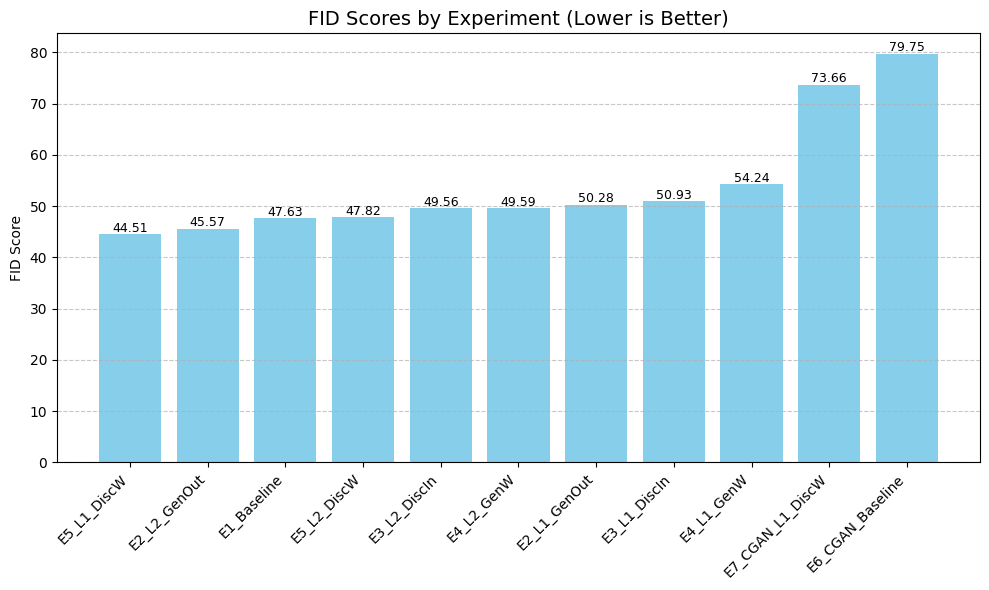

In [ ]:
# FID data
fid_data = {
    'Experiment': ['E5_L1_DiscW', 'E2_L2_GenOut', 'E1_Baseline', 'E5_L2_DiscW',
                   'E3_L2_DiscIn', 'E4_L2_GenW', 'E2_L1_GenOut', 'E3_L1_DiscIn',
                   'E4_L1_GenW', 'E7_CGAN_L1_DiscW', 'E6_CGAN_Baseline'],
    'FID Score': [44.51, 45.57, 47.63, 47.82, 49.56, 49.59, 50.28, 50.93,
                  54.24, 73.66, 79.75]
}

df_fid = pd.DataFrame(fid_data).sort_values('FID Score')

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df_fid['Experiment'], df_fid['FID Score'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('FID Scores by Experiment (Lower is Better)', fontsize=14)
plt.ylabel('FID Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

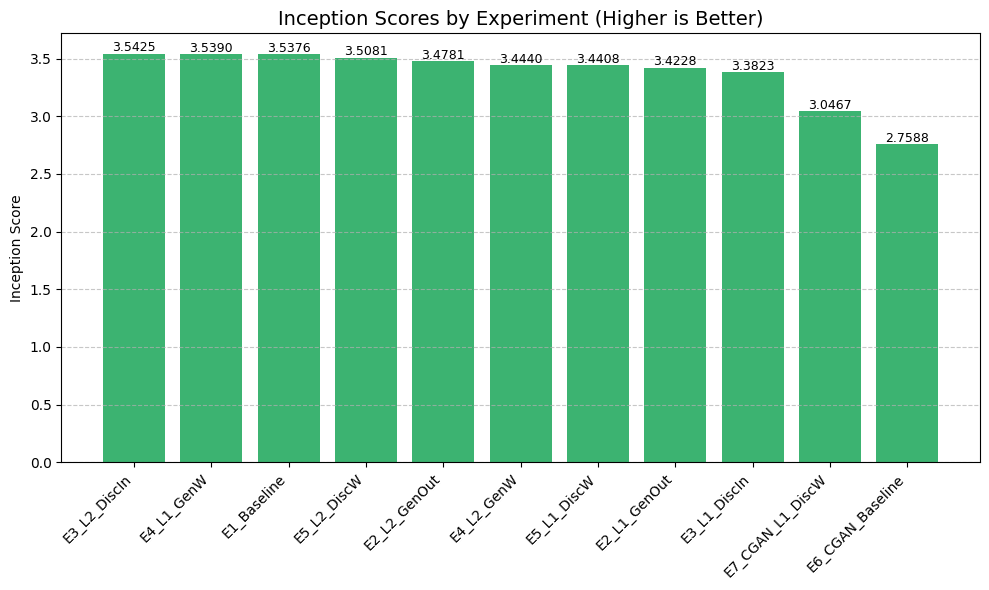

In [ ]:
# IS data
is_data = {
    'Experiment': ['E3_L2_DiscIn', 'E4_L1_GenW', 'E1_Baseline', 'E5_L2_DiscW',
                   'E2_L2_GenOut', 'E4_L2_GenW', 'E5_L1_DiscW', 'E2_L1_GenOut',
                   'E3_L1_DiscIn', 'E7_CGAN_L1_DiscW', 'E6_CGAN_Baseline'],
    'IS Score': [3.5425, 3.5390, 3.5376, 3.5081, 3.4781, 3.4440, 3.4408,
                 3.4228, 3.3823, 3.0467, 2.7588]
}

df_is = pd.DataFrame(is_data).sort_values('IS Score', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df_is['Experiment'], df_is['IS Score'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.title('Inception Scores by Experiment (Higher is Better)', fontsize=14)
plt.ylabel('Inception Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()